Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
import torch.nn as nn

%matplotlib inline

# Stochastic gradient Langevin dynamics, and uncertainty quantification

In this second part of the coursework you'll do two things:

* Implement stochastic gradient Langevin dynamics for sampling from a Bayesian neural network
* Break down the variance to estimate epistemic and aleatoric uncertainty

We're going to run this on the following toy 2D dataset, consisting of **two moons**, each a different class.

(-2.0, 2.0)

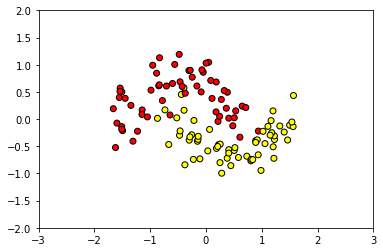

In [2]:
dataset, validation_set = torch.load("two_moons.pt")
X_train, y_train = dataset.tensors
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k');
plt.xlim(-3,3)
plt.ylim(-2,2)

## We'll use the following simple feedforward network.

In [3]:
class TwoMoonsNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(2, 100),
                        nn.ReLU(), 
                        nn.Linear(100, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
        
    def forward(self, x):
        h = self.net(x)
        return torch.sigmoid(h).squeeze(1)
    
network = TwoMoonsNetwork()

In [5]:
for i, items in enumerate(network.parameters()):
    print(items.shape)

torch.Size([100, 2])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])
torch.Size([1, 10])
torch.Size([1])


# TASK 1 (5 points): Define the likelihood and the prior

Let $x_i \in \mathbb{R}^2$ denote an input, $y_i \in \{ 0, 1\}$ a target, and $\theta$ the network parameters.

Let $\hat y_i = f_\theta(x_i)$ denote the output of the network $f_\theta$.

You need to define:

* `log_likelihood`, evaluating a Bernoulli distribution $$\log p(y|x, \theta) = \log \mathrm{Bernoulli}(y | f_\theta(x));$$
* `log_prior`, evaluating a standard normal distribution $$\log p(\theta) = \log \mathcal{N}(\theta | 0, I).$$

Both of these functions should return a numeric scalar value.

For the prior, you will need to somehow access the parameters of the network! There are several ways of doing this. I suggest looking at the pytorch documentation for either

* iterating through `network.parameters()`, or
* using helper functions such as `nn.utils.parameters_to_vector`



In [6]:
def log_likelihood(network, X, y):
    """
    This function computes the log probability `log p(y | x, theta)`
    for a batch of inputs X.
    
    INPUT:
    network : instance of classifier network, extends `nn.Module`
    X       : batch of inputs; torch.FloatTensor, matrix of shape = (batch_size, 2)
    y       : batch of targets: torch.FloatTensor, vector of shape = (batch_size,)
    
    OUTPUT:
    lp      : log probability value of log p(y | x, theta); scalar
    
    """
    # YOUR CODE HERE
    
    distrib = dist.Bernoulli(network.forward(X))
    
    log_prob = torch.sum(distrib.log_prob(y))
    
    return log_prob


In [7]:
# grading


In [8]:
def log_prior(network):
    # YOUR CODE HERE
    
    
    params = network.parameters()
    param_vector = nn.utils.parameters_to_vector(params)
    
    distrib = dist.MultivariateNormal(torch.zeros((param_vector.shape[0])), torch.eye(param_vector.shape[0]))

    log_prior_prob = torch.sum(distrib.log_prob(param_vector))
    
    return log_prior_prob

In [10]:
# grading


In [11]:
# grading


## TASK 2 (3 points): Minibatching

Minibatching is "trickier" when we have a prior on the network parameters.

The function `log_joint_minibatch` should return a mini-batch estimate of the log joint of the full data, i.e. returning an estimator of $$\log p(\theta) + \sum_{i=1}^N \log p(y_i | x_i, \theta)$$ but which is evaluated on only the specified subset of the $N$ data points.

In [12]:
def log_joint_minibatch(network, X_batch, y_batch, N_training):
    """ Return a minibatch estimate of the full log joint probability 
    
    INPUT:
    network    : instance of classifier network, extends `nn.Module`
    X_batch    : batch of inputs; torch.FloatTensor, matrix of shape = (batch_size, 2)
    y_batch    : batch of targets: torch.FloatTensor, vector of shape = (batch_size,)
    N_training : total number of training data instances in the full training set

    OUTPUT:
    lp : return an estimate of log p(y, theta | X), as computed on the batch; scalar.

    """
    # YOUR CODE HERE
    
    log_sum = N_training/y_batch.shape[0] * log_likelihood(network, X_batch, y_batch)
    
    logjoint = log_prior(network) + log_sum
    
    return logjoint

In [13]:
# grading


In [14]:
# grading


## Self-diagnostic

This is a small-enough dataset that we can compute the log joint probability on the whole dataset:

In [15]:
with torch.no_grad():
    full_data_lp = log_prior(network) + log_likelihood(network, X_train, y_train)
print("Full data log probability: %0.4f" % full_data_lp.item())

Full data log probability: -1327.4878


### In the next cell, we call `log_joint_minibatch`.

If all the code is working correctly, the minibatch estimates should be roughly normally-distributed around the true value!

Changing the batch size should not change the mean of this distribution. Try running the cell below several times.

If the histogram is far away from the true value (the black vertical dashed line), then you probably have a bug.

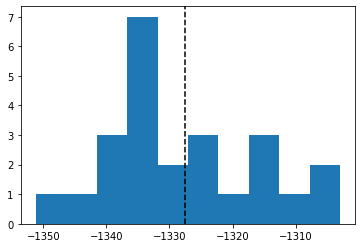

In [16]:
dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=5)

with torch.no_grad():
    batch_lp_est = [log_joint_minibatch(network, X, y, len(dataset)).item() for X, y in dataloader]
plt.hist(batch_lp_est, bins=10);
yl = plt.ylim()
plt.plot(full_data_lp.item()*np.ones(2), [0, plt.ylim()[1]], 'k--')
plt.ylim(yl);
# torch.stack(batch_lp_est).sum()

## Train the model (MAP estimation)

Run the following cell to train your model, to find a MAP estimate.

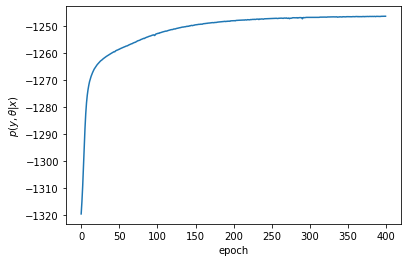

In [17]:
dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=5)
opt = torch.optim.Adam(network.parameters())

N_epochs = 400
train_lp = []

for epoch in range(N_epochs):
    for X, y in dataloader:
        opt.zero_grad()
        loss = -log_joint_minibatch(network, X, y, len(dataset))
        loss.backward()
        opt.step()
    with torch.no_grad():
        train_lp.append((log_likelihood(network, X_train, y_train) + log_prior(network)).item())
plt.plot(train_lp)
plt.xlabel("epoch")
plt.ylabel("$p(y, \\theta | x)$");

## Confidence plot

To visualize the result, we'll look at a *confidence plot*.

The *confidence* is the probability assigned to whichever class is predicted.

If the most likely class is "yellow", then it shows $p(y = \text{yellow})$. If the most likely class is red, it shows $p(y = \text{red})$.



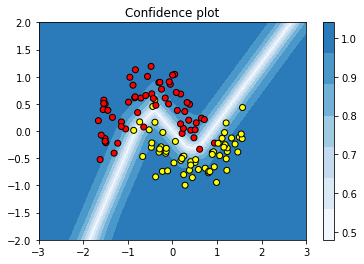

In [18]:
XX, YY = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-2, 2, 100))
with torch.no_grad():
    py = network(torch.FloatTensor(np.stack((XX.ravel(), YY.ravel())).T))
    conf = torch.where(py > 0.5, py, 1-py) ## THIS LINE COMPUTES THE CONFIDENCE
    ZZ = conf.reshape(XX.shape)
CS = plt.contourf(XX, YY, ZZ, cmap='Blues', vmin=0.5, vmax=1.2)
plt.colorbar(ticks=np.linspace(0.5, 1, 6))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k')
plt.title("Confidence plot");

# Calibration and reliability diagrams

I've implemented a reliability diagram plot and expected calibration error computation here.

Could be interesting to see how the number of bins affects the result…!

In [19]:
def reliability_diagram(y, y_hat, N_bins=10):
    """
    Plot a reliabiltiy diagram
    """
    bins = torch.linspace(0, 1, N_bins+1)
    which_bin = (y_hat[:,None] >= bins[1:]).long().sum(-1).numpy()
    freq = [y[which_bin==k].mean().item() for k in range(N_bins)]
    conf = [y_hat[which_bin==k].mean().item() for k in range(N_bins)]
    plt.bar(bins[1]/2+np.arange(N_bins)/N_bins, freq, width=bins[1]*.9);
    plt.plot(conf, freq, 'o-', color='k')
    plt.plot([0, 1], [0, 1], '--', color='#333');

def expected_calibration_error(y, y_hat, N_bins=10):
    """
    Compute the expected calibration error
    """
    bins = torch.linspace(0, 1, N_bins+1)
    which_bin = (y_hat[:,None] >= bins[1:]).long().sum(-1).numpy()
    counts = []
    acc = []
    conf = []
    for k in range(N_bins):
        count = len(y[which_bin==k])
        if count > 0:
            acc.append(y[which_bin==k].mean().item())
            conf.append(y_hat[which_bin==k].mean().item())
        else:
            acc.append(0.0)
            conf.append(0.0)
        counts.append(count)
    return ((np.abs(np.array(acc) - np.array(conf))*np.array(counts))/len(y)).sum()

ECE = 0.0412


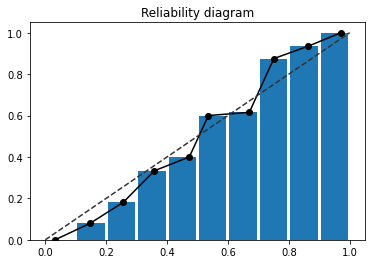

In [20]:
with torch.no_grad():
    y_hat = network(validation_set.tensors[0])

reliability_diagram(y=validation_set.tensors[1], y_hat=y_hat)
print("ECE = %0.4f" % expected_calibration_error(validation_set.tensors[1], y_hat))
plt.title("Reliability diagram");

# TASK 3 (6 points): stochastic gradient Langevin dynamics (SGLD)

In this task you can get

* 3 points for implementing the SGLD MCMC update
* 3 points for implementing Monte Carlo prediction

The `SGLD_step` function below should take a current set of network parameters $\theta$, and update them as

$$\theta' = \theta + \frac{\epsilon^2}{2} \nabla_\theta \log p(\theta, y | X) + \epsilon z$$

where $\epsilon$ is a learning rate, $X, y$ are a current mini-batch, and $z \sim \mathcal{N}(0, I)$ and has the same dimensionality as $\theta$.

For more details see the week 7 lecture slides!

Note that you will actually have to **do the update**. The following function does not return anything! Instead, it updates the parameters of the network, similar to how a `torch.optim` optimizer updates the parameters.

In [21]:
def SGLD_step(network, X, y, N_training, epsilon):
    """
    Run one step of SGLD given a mini-batch, and update the parameters of the network.
    
    INPUT:
    network    : instance of classifier network, extends `nn.Module`
    X_batch    : batch of inputs; torch.FloatTensor, matrix of shape = (batch_size, 2)
    y_batch    : batch of targets: torch.FloatTensor, vector of shape = (batch_size,)
    N_training : total number of training data instances in the full training set
    epsilon    : step size / learning rate parameters (scalar)
    """
    # YOUR CODE HERE
    
    network.zero_grad()
    thetas = nn.utils.parameters_to_vector(network.parameters())
    
    loss = log_joint_minibatch(network, X, y, N_training)
    loss.backward()
    
    grads = nn.utils.parameters_to_vector([theta.grad for theta in network.parameters()])
    
    z_dist = dist.MultivariateNormal(torch.zeros((thetas.shape[0])), torch.eye(thetas.shape[0]))
    
    thetas_prime = thetas + ((epsilon**2) / 2) * grads + epsilon*z_dist.sample()
    
    nn.utils.vector_to_parameters(thetas_prime, network.parameters())

In [22]:
# grading


In [23]:
# grading


### Cyclic learning rate 

We're going to use a cyclic learning rate schedule for $\epsilon$, like discussed in the lectures. That function is pre-written, below.

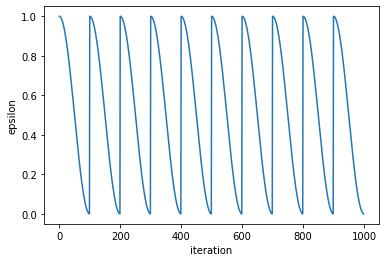

In [24]:
def learning_rate_schedule(N_steps, N_samples, epsilon):
    """
    Pre-compute a learning-rate schedule for SGLD.
    
    INPUT:
    N_steps   : number of SGD updates between each "reset"
    N_samples : number of times we reach the lowest target learning rate
    epsilon   : base learning rate
    
    OUTPUT:
    epsilon_t : vector of length N_steps*N_samples, containing epsilon_t at each iteration t
    """
    return epsilon * (np.cos(np.pi * (np.arange(N_samples*N_steps) % N_steps)/N_steps) + 1)

plt.plot(learning_rate_schedule(N_steps=100, N_samples=10, epsilon=0.5));
plt.xlabel("iteration");
plt.ylabel("epsilon");

### Running the sampler
The following function is also given: it will actually run the SGLD sampler, by calling your `SGLD_step` function above.

In [25]:
def draw_sgld_samples(network, N_samples, N_steps_per_sample, base_epsilon=0.02):
    """
    Draw samples using SGLD, following a prescribed learning rate schedule
    
    OUTPUT:
    samples : torch.FloatTensor, shape = (N_samples, "# of parameters in network")
    """
    lr_schedule = learning_rate_schedule(N_steps_per_sample, N_samples, base_epsilon)
    samples = []
    step = 0
    while True:
        for X, y in dataloader:
            SGLD_step(network, X, y, len(dataset), epsilon=lr_schedule[step])
            step += 1
            if step % N_steps_per_sample == 0:
                samples.append(nn.utils.parameters_to_vector(network.parameters()).detach())
            if step == len(lr_schedule):
                return torch.stack(samples)


In [26]:
samples = draw_sgld_samples(network, N_samples=50, N_steps_per_sample=200) #50. 200
print("Tensor holding samples of theta has shape:", samples.shape)

Tensor holding samples of theta has shape: torch.Size([50, 1321])


## Making predictions

After running the sampler, you now have a `torch.FloatTensor` which contains many different sampled versions of the network parameters $s = 1,\dots,S$.

To make predictions on an input batch $X$, you will somehow need to "load" in the stored parameters, and run the forward pass using different $\theta^{(s)}$.

In [27]:
def predict_from_samples(X, network, samples):
    """
    
    INPUT:
    X       : batch of input points at which to make predictions; shape = (batch_size, 2)
    network : instance of classifier network, extends `nn.Module`
    samples : torch.FloatTensor containing samples of theta; shape = (num_samples, "# of parameters in network")
    
    OUTPUT:
    y_hat_samples : torch.FloatTensor containing samples of y_hat; shape = (num_samples, batch_size)
    """
    # YOUR CODE HERE

    y_hat_samples = torch.zeros((samples.shape[0], X.shape[0]))
    
    for n in range(samples.shape[0]):
        nn.utils.vector_to_parameters(samples[n,:], network.parameters())
        pred = network.forward(X)
        y_hat_samples[n,:] = pred
        
    return y_hat_samples
    
    

In [28]:
# The following should be true if your code is working!
assert predict_from_samples(X_train, network, samples).shape == (samples.shape[0], X_train.shape[0])

In [29]:
# grading


In [30]:
# grading


## Confidence plot and reliability diagrams for the Bayesian classifier

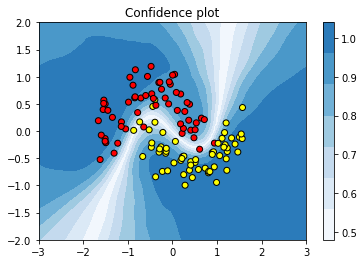

In [31]:
XX, YY = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-2, 2, 100))
with torch.no_grad():
    XXYY = torch.FloatTensor(np.stack((XX.ravel(), YY.ravel())).T)
    out = predict_from_samples(XXYY, network, samples)
    py = out.mean(0)
    conf = torch.where(py > 0.5, py, 1-py)
    ZZ = conf.reshape(XX.shape)
CS = plt.contourf(XX, YY, ZZ, cmap='Blues', vmin=0.5, vmax=1.2)
plt.colorbar(ticks=np.linspace(0.5, 1, 6))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k');
plt.title("Confidence plot");

ECE = 0.0513


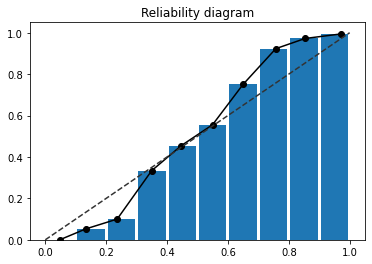

In [32]:
with torch.no_grad():
    y_hat = predict_from_samples(validation_set.tensors[0], network, samples).mean(0)

reliability_diagram(y=validation_set.tensors[1], y_hat=y_hat)
print("ECE = %0.4f" % expected_calibration_error(validation_set.tensors[1], y_hat))

plt.title("Reliability diagram");

## Uncertainty quantification

We can measure the uncertainty in our predictor by looking at the variance of the predictive distribution

$$p(y | \hat y).$$

Here, $\hat y$ is the posterior mean: the average $p(y = 1)$ estimated across all posterior samples.

The total predictive variance of $y$ is the variance of this distribution, i.e.

$$Var [ y | x ] = Var \left [ \int p(y | x, \theta)p(\theta | \mathcal{D}) d\theta \right]$$

One way to estimate epistemic and aleatoric uncertainty is to look at the variance of $\hat y$, i.e. the variance in $f_\theta(x)$ under the posterior over $\theta$. This corresponds to epistemic uncertainty. The difference between these two is then roughly the aleatoric uncertainty.

There are probably better ways to compute (and explain!) this, but hopefully the following plots look clear.

In [33]:
# Variance of predictive distribution over y
var_of_prediction = dist.Bernoulli(out.mean(0)).variance

# Epistemic uncertainty: Variance across values of y_hat
var_of_mean = out.var(0)



### Darker colors are more uncertain:

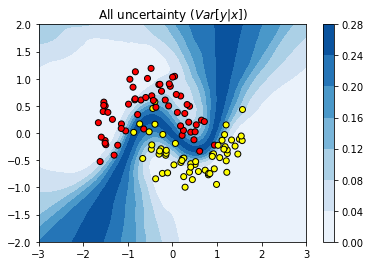

In [34]:
plt.title("All uncertainty ($Var[y | x]$)")
plt.contourf(XX, YY, var_of_prediction.reshape(XX.shape), cmap='Blues', vmin=0, vmax=0.3)
plt.colorbar();
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k');
# - torch.sigmoid(out).var(0).reshape(XX.shape))

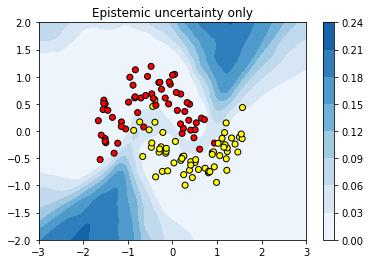

In [35]:
plt.title("Epistemic uncertainty only")
plt.contourf(XX, YY, var_of_mean.reshape(XX.shape), cmap='Blues', vmin=0, vmax=0.28)
plt.colorbar();
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k');

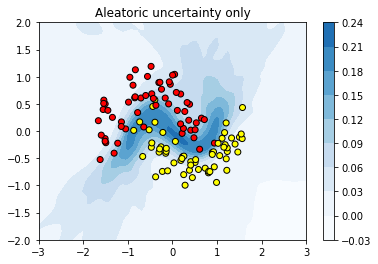

In [36]:
plt.title("Aleatoric uncertainty only")
plt.contourf(XX, YY, (var_of_prediction - var_of_mean).reshape(XX.shape), cmap='Blues', vmin=0, vmax=0.3)
plt.colorbar();
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k');

# Extra credit (up to 5 points): Interpretation

Take a look at Figure 1 in the paper https://arxiv.org/pdf/2002.10118.pdf.

1. (4 points) Qualitatively, the uncertainty in figure 1 probably looks quite different from your plots in this notebook. Try to give two different reasons for why the results here might be different.
2. (1 point) What is going on with calibration / temperature scaling? Why doesn't the temperature scaling help in Figure 1 in the paper, and why doesn't the ECE improve in this case when we do sampling?

YOUR ANSWER HERE

1) We can see that in the paper, any region far away from the data has low confidence. This intuitevely makes more sense and is what we would wish to have. We have very high confidence in regions where there is no data: this isn't Bayesian. We are learning parameters to learn a classification with a sigmoid. The paper learns a gaussian distribution, this means that further from the data there will be lower confidence because the probability will go to 0. Our network a boundary to fit he data using a sigmoid function. This means that we still can get full confidence when we move away from the data due to the shape of the sigmoid function. 
Reason 1: We are learning a boundary for the data, the paper is learning a distribution on the data. 
Reason 2: We are using a sigmoid with SGLD optimised parameters to classify, the paper is using a Laplace approximation.

2) Temperature scaling won't help as it uses the results of the network and then just scales the labels by a constant. We can see that the boundary of uncertainty is a lot less wide in the temperature scaling case compared to the normal MAP case. Temperature scaling is done on the last step of the network at the classification stage, therefore it won't affect the ECE significantly.
